# Using Regressional Analysis to better understand the ADNI Database:

#### Read the database and select for each person the datapoint with their first MRI Scan:

In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style="darkgrid")

data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV_baseline',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4', 'DLICV_baseline'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
print(unique.shape)
unique.head(10)

(1569, 207)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,...,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,1586.249283,302.695176,352.265466,1062.069832,1159.101038,20657.100036,3254.764153,3118.709527,52564.546547,52086.773326,14018.899912,14294.173225,3600.701497,3368.670352,750.937160,587.460672,16514.289409,23626.044006,1544.061802,1339.452519,4182.888734,4105.896581,7365.934170,8007.183880,4747.146291,4789.333772,4638.513528,2017.616275,2812.850291,352.265466,380.742015,...,1,1,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,1505.034469,384.959763,340.663023,988.239172,1051.520229,18405.295394,3021.670466,3151.396633,45240.682248,43280.024169,12993.710346,13640.231811,3586.981241,3350.731962,475.662611,761.482051,16498.426213,13491.521327,1096.871653,1092.652915,2941.514461,3243.154165,6479.980225,6874.432146,4181.823176,4367.447609,3893.894367,1782.416435,2235.930676,503.084402,371.248867,...,2,2,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,3157.732947,512.577893,552.656000,1172.811970,1141.171359,23368.700372,3041.717375,3198.865741,49984.782089,49158.962150,17229.367210,17536.281134,4728.161925,4206.091848,764.648092,640.195023,16674.601836,16115.617714,1304.647848,1335.233771,4119.607512,4195.544978,7287.887330,7510.426292,5413.708490,5620.427146,3802.146719,1700.155481,2524.920733,563.202870,591.679420,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,2981.605944,280.547287,356.484899,876.446600,908.087272,21112.765397,2883.519862,2848.715123,56650.512928,55319.495347,13810.098417,14307.911649,3485.747309,3231.567248,1810.901098,1584.142953,47125.616120,60669.932896,1393.244235,1401.681747,3791.607134,3956.138626,7059.033810,7534.698571,5230.202998,5155.320075,4848.405562,2089.339007,3279.028256,557.930507,343.828630,...,1,1,1,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,1693.826402,278.437217,328.007479,910.194387,966.092767,19718.417441,3275.856043,3304.332576,48017.763654,46338.702862,15370.999989,15619.905986,3663.980648,3558.512005,850.077260,378.632427,19563.378537,20767.830436,1211.834705,1276.170577,3940.308492,3830.621103,6907.141411,7299.484762,4610.034373,4816.752913,4007.808423,1973.318305,3543.746395,275.273157,261.562234,...,0,1,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,1,2,2,0,0,0,0,0,2,0,0,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,1921.643449,356.484899,415.547486,761.485494,853.243441,18195.495486,3485.747309,2921.488668,44029.049070,42879.438005,11626.892084,12026.619234,2887.738618,2592.425684,392.344326,283.711354,8403.762348,9388.841921,1287.775330,1255.079969,3543.755207,3659.771003,6422.001624,6685.673886,

In [194]:
unique.describe()

,Age,Sex,DLICV_baseline,APOE4_Alleles,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,MUSE_Volume_81,MUSE_Volume_82,MUSE_Volume_83,MUSE_Volume_84,...,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
count,1569.000000,1569.000000,1.569000e+03,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,...,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000
mean,73.812706,0.435946,1.428620e+06,0.572339,1759.904008,1747.717480,354.478153,390.749666,934.294280,982.667200,20203.581654,3176.564823,3074.165243,48498.469808,47539.394721,13476.420408,13759.419417,3558.725286,3263.763321,788.852817,746.075692,20070.647403,22249.756978,1357.089959,1375.650725,3946.708991,3986.087361,6942.077591,7132.378188,4462.325357,4633.318953,4207.679175,2121.887627,2863.304281,342.175734,316.170427,93508.755911,90995.475346,23701.768308,23752.946415,...,0.751434,0.713193,0.632250,0.555131,0.574888,0.364563,0.960484,0.684512,0.732951,0.735500,0.768642,0.776928,0.797323,0.824729,0.888464,0.644997,0.790312,0.758445,0.775653,0.609305,0.703633,0.703633,0.180370,0.181007,0.444232,0.449331,0.664755,0.648821,0.576801,0.264500,0.950287,0.342894,0.355003,0.360102,0.167623,0.590822,0.176546,0.182282,0.179095,0.569152
std,7.145385,0.496038,1.438380e+05,0.667217,776.728901,579.875616,65.298739,70.724769,162.692143,167.668430,2242.618234,489.416788,441.744139,5119.042719,5019.717105,1595.642038,1611.947012,558.420284,517.967850,659.333174,628.419311,10925.938437,12181.553631,167.698005,169.747394,513.158047,512.539756,698.255114,699.049779,468.834721,491.499585,574.739522,298.178314,412.046799,113.914256,117.268309,12337.292063,11938.633043,3413.612166,3623.999522,...,0.689322,0.677130,0.656992,0.639615,0.645555,0.550666,0.703286,0.679902,0.701268,0.704048,0.680925,0.680413,0.693238,0.695650,0.704161,0.647436,0.701680,0.693193,0.699412,0.646569,0.671575,0.671575,0.407171,0.407670,0.586503,0.588052,0.666079,0.674565,0.633360,0.486575,0.711657,0.533043,0.545893,0.550708,0.380416,0.642514,0.407281,0.411775,0.407733,0.666599
min,54.273973,0.000000,1.057343e+06,0.000000,279.599289,649.198349,188.787377,219.599442,428.399974,465.599972,14147.216048,1785.595459,1909.195145,33671.250000,32319.375000,8848.799473,9111.599457,1739.177918,1655.858626,34.799911,2.475464,2818.799832,3604.799785,913.199946,903.866268,2608.241008,2521.249264,4339.488159,4380.115207,3168.750000,3248.437500,2570.267046

#### Performing Regressional Analysis to uncover the relation between age, sex and ROIs:

In [195]:
age_mask =      (unique['Age']>=68)   &   (unique['Age']<=83)
CN_mask =       (unique['Age']>=68)   &   (unique['Age']<=83)   &   (unique['Diagnosis_nearest_2.0'] == 'CN') 
MCI_mask =      (unique['Age']>=68)   &   (unique['Age']<=83)   &   (unique['Diagnosis_nearest_2.0'] == 'MCI')
AD_mask =       (unique['Age']>=68)   &   (unique['Age']<=83)   &   (unique['Diagnosis_nearest_2.0'] == 'Dementia')

-------------------------------------------------------------- ROI  MUSE_Volume_48  --------------------------------------------------------------
Coefficients: 			 [[-2.80696405e+01 -4.58995469e+00  1.59619563e-03]] 

Intercept: 			 [3333.11606281] 

Mean squared error: 		 271512.66 

Coefficient of determination: 	 -0.06 



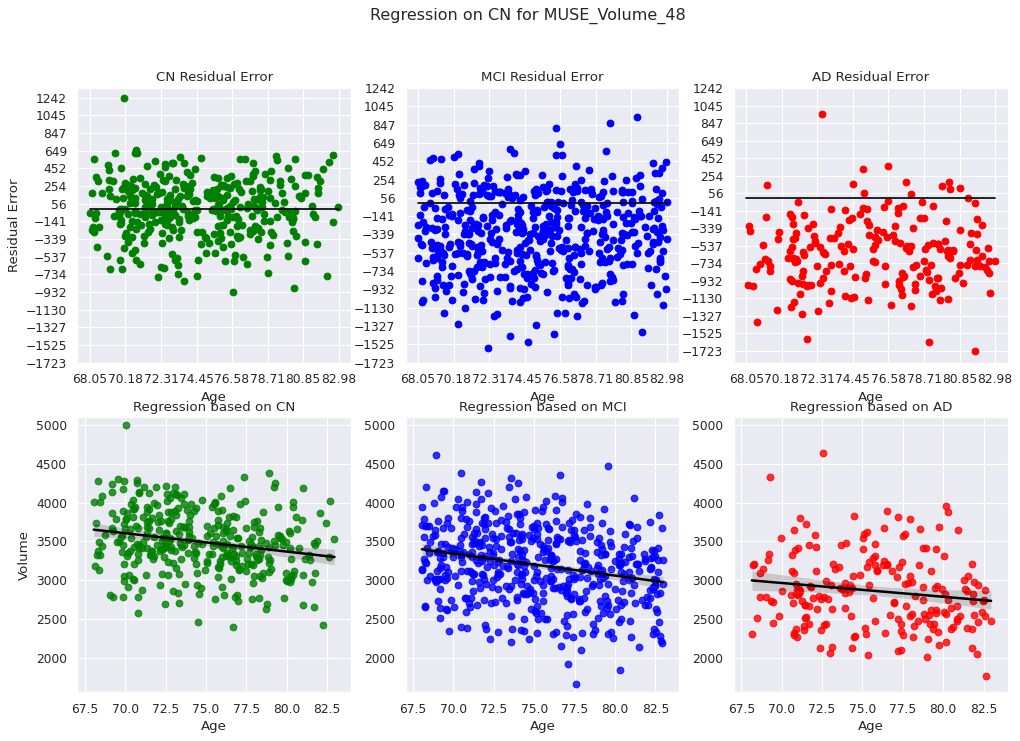

In [333]:
X = unique[['Age','Sex','DLICV_baseline']].values
Y = unique[['MUSE_Volume_48']].values

regr = LinearRegression().fit(X[CN_mask],Y[CN_mask])

Y_pred = Y.copy()
Y_pred = regr.predict(X)
Y_resid = Y - Y_pred

print("-------------------------------------------------------------- ROI ", "MUSE_Volume_48",  " --------------------------------------------------------------")
# The coefficients
print("Coefficients: \t\t\t", regr.coef_, "\n")
# The intercept
print("Intercept: \t\t\t", regr.intercept_, "\n")
# The mean squared error
print("Mean squared error: \t\t %.2f" % mean_squared_error(Y[age_mask], Y_pred[age_mask]), "\n")
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: \t %.2f" % r2_score(Y[age_mask], Y_pred[age_mask]), "\n")

fig, ax_arr = plt.subplots(nrows=2,ncols=3,figsize=(15,10), dpi=80)

ax_arr[0,0].scatter(X[CN_mask][:,0], Y_resid[CN_mask], color="green")
ax_arr[0,1].scatter(X[MCI_mask][:,0], Y_resid[MCI_mask], color="blue")
ax_arr[0,2].scatter(X[AD_mask][:,0], Y_resid[AD_mask], color="red")

x = np.linspace(   min(X[age_mask][:,0]), max(X[age_mask][:,0]), num=len(X[CN_mask][:,0])   )
y = y = 0 * x
ax_arr[0,0].plot(x, y, color='black')
ax_arr[0,1].plot(x, y, color='black')
ax_arr[0,2].plot(x, y, color='black')

ax_arr[0,0].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
ax_arr[0,0].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
ax_arr[0,1].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
ax_arr[0,1].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
ax_arr[0,2].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
ax_arr[0,2].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))


ax_arr[0,0].set_title("CN Residual Error")
ax_arr[0,0].set_xlabel('Age')
ax_arr[0,0].set_ylabel('Residual Error')
ax_arr[0,1].set_title("MCI Residual Error")
ax_arr[0,1].set_xlabel('Age')
ax_arr[0,2].set_title("AD Residual Error")
ax_arr[0,2].set_xlabel('Age')

sns.regplot(x=X[CN_mask][:,0], y=Y[CN_mask], 
            color = 'green', 
            scatter=True, 
            ax = ax_arr[1,0],
            line_kws={'color':"black"})
sns.regplot(x=X[MCI_mask][:,0], y=Y[MCI_mask], 
            color = 'blue', 
            scatter=True, 
            ax = ax_arr[1,1],
            line_kws={'color':"black"})
sns.regplot(x=X[AD_mask][:,0], y=Y[AD_mask], 
            color = 'red', 
            scatter=True, 
            ax = ax_arr[1,2],
            line_kws={'color':"black"})

ax_arr[1,0].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
ax_arr[1,1].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
ax_arr[1,2].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
ax_arr[1,0].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
ax_arr[1,1].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
ax_arr[1,2].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)

ax_arr[1,0].set_title("Regression based on CN")
ax_arr[1,0].set_xlabel('Age')
ax_arr[1,0].set_ylabel('Volume')
ax_arr[1,1].set_title("Regression based on MCI")
ax_arr[1,1].set_xlabel('Age')
ax_arr[1,2].set_title("Regression based on AD")
ax_arr[1,2].set_xlabel('Age')

fig.suptitle("Regression on CN for MUSE_Volume_48")
plt.show()
print("\n\n")

#### Perform Regression for each of the ROIs, find residuals, and replace the ROI values with those:

In [335]:
def Find_residuals(df, ROI_name, pp=False, min_age=68, max_age=83):
    X = df[['Age','Sex','DLICV_baseline']].values
    Y = df[[ROI_name]].values

    age_mask =      (df['Age']>=min_age)   &   (df['Age']<=max_age)
    CN_mask =       (df['Age']>=min_age)   &   (df['Age']<=max_age)   &   (df['Diagnosis_nearest_2.0'] == 'CN') 
    MCI_mask =      (df['Age']>=min_age)   &   (df['Age']<=max_age)   &   (df['Diagnosis_nearest_2.0'] == 'MCI')
    AD_mask =       (df['Age']>=min_age)   &   (df['Age']<=max_age)   &   (df['Diagnosis_nearest_2.0'] == 'Dementia')

    regr = LinearRegression().fit(X[CN_mask],Y[CN_mask])

    Y_pred = Y.copy()
    Y_pred = regr.predict(X)
    Y_resid = Y - Y_pred
    
    if not pp:
        return Y_resid


    print("-------------------------------------------------------------- ROI ", ROI_name,  " --------------------------------------------------------------")
    # The coefficients
    print("Coefficients: \t\t\t", regr.coef_, "\n")
    # The intercept
    print("Intercept: \t\t\t", regr.intercept_, "\n")
    # The mean squared error
    print("Mean squared error: \t\t %.2f" % mean_squared_error(Y[age_mask], Y_pred[age_mask]), "\n")
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: \t %.2f" % r2_score(Y[age_mask], Y_pred[age_mask]), "\n")

    fig, ax_arr = plt.subplots(nrows=2,ncols=3,figsize=(15,10), dpi=80)

    ax_arr[0,0].scatter(X[CN_mask][:,0], Y_resid[CN_mask], color="green")
    ax_arr[0,1].scatter(X[MCI_mask][:,0], Y_resid[MCI_mask], color="blue")
    ax_arr[0,2].scatter(X[AD_mask][:,0], Y_resid[AD_mask], color="red")

    x = np.linspace(   min(X[age_mask][:,0]), max(X[age_mask][:,0]), num=len(X[CN_mask][:,0])   )
    y = y = 0 * x
    ax_arr[0,0].plot(x, y, color='black')
    ax_arr[0,1].plot(x, y, color='black')
    ax_arr[0,2].plot(x, y, color='black')

    ax_arr[0,0].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
    ax_arr[0,0].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
    ax_arr[0,1].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
    ax_arr[0,1].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
    ax_arr[0,2].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
    ax_arr[0,2].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))


    ax_arr[0,0].set_title("CN Residual Error")
    ax_arr[0,0].set_xlabel('Age')
    ax_arr[0,0].set_ylabel('Residual Error')
    ax_arr[0,1].set_title("MCI Residual Error")
    ax_arr[0,1].set_xlabel('Age')
    ax_arr[0,2].set_title("AD Residual Error")
    ax_arr[0,2].set_xlabel('Age')

    sns.regplot(x=X[CN_mask][:,0], y=Y[CN_mask], 
                color = 'green', 
                scatter=True, 
                ax = ax_arr[1,0],
                line_kws={'color':"black"})
    sns.regplot(x=X[MCI_mask][:,0], y=Y[MCI_mask], 
                color = 'blue', 
                scatter=True, 
                ax = ax_arr[1,1],
                line_kws={'color':"black"})
    sns.regplot(x=X[AD_mask][:,0], y=Y[AD_mask], 
                color = 'red', 
                scatter=True, 
                ax = ax_arr[1,2],
                line_kws={'color':"black"})

    ax_arr[1,0].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
    ax_arr[1,1].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
    ax_arr[1,2].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
    ax_arr[1,0].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
    ax_arr[1,1].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
    ax_arr[1,2].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)

    ax_arr[1,0].set_title("Regression based on CN")
    ax_arr[1,0].set_xlabel('Age')
    ax_arr[1,0].set_ylabel('Volume')
    ax_arr[1,1].set_title("Regression based on MCI")
    ax_arr[1,1].set_xlabel('Age')
    ax_arr[1,2].set_title("Regression based on AD")
    ax_arr[1,2].set_xlabel('Age')

    fig.suptitle("Regression on CN for " + ROI_name)
    plt.show()
    print("\n\n")

    return Y_resid

In [ ]:
for roi in MRI_columns:
    y_res = Find_residuals(unique, roi)
    unique[roi] = y_res

In [344]:
unique.head(10)

,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,...,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-440.777069,-507.297168,-35.171797,-14.510211,90.244138,140.075639,299.828133,63.889680,56.259492,4434.963481,4675.998381,381.769404,327.754301,-6.631946,43.247268,-163.129012,-302.019500,-9092.950896,-5970.491235,243.716333,22.707872,255.902346,141.625578,546.689657,1024.164078,254.110609,93.947490,555.786493,-115.968921,-8.702315,28.975577,83.444761,...,1,1,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,577.755137,-188.813792,35.574764,-39.881572,40.161648,58.255314,-909.956510,-107.325098,118.445748,-932.590538,-2243.094496,-58.295425,320.690365,-66.958765,-13.937994,-50.578227,272.509078,-1257.603129,-6295.811070,-209.193067,-234.853159,-833.004865,-578.211144,-312.172328,-101.898838,-74.783269,-55.047404,-223.523619,-256.111266,-434.940788,151.791151,46.343513,...,2,2,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,198.499249,1080.290951,137.416288,142.586830,121.231074,41.449232,1825.886437,-267.694901,6.605333,-947.176391,-867.100746,2838.422483,2840.370315,811.792613,589.952274,-21.050722,-135.878688,-7432.189229,-11220.838081,-92.329076,-79.973841,14.942542,29.812463,-14.503777,5.409497,652.266108,655.077123,-511.180672,-509.970220,-467.322212,201.237813,259.978127,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2623.687012,649.558822,-162.939446,-122.191780,-329.934406,-351.510297,-3426.992838,-826.297201,-713.213854,-355.750507,-609.335762,-2692.886301,-2508.935803,-981.186288,-895.496387,949.207055,693.097091,17264.269959,26986.534671,-188.708309,-192.899835,-717.185909,-672.991314,-1274.964380,-1046.340376,-182.237984,-505.379013,101.003978,-323.398238,-6.753286,125.526868,-43.544169,...,1,1,1,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,727.400228,-250.782773,-27.195126,6.992014,48.594085,57.675286,1120.707525,136.378936,316.063586,4364.772160,2976.649699,2606.734893,2515.944522,385.321947,552.592515,-80.711237,-506.777557,-6892.763170,-10230.017646,12.651686,65.004905,310.075986,168.632232,562.264942,837.847347,538.330584,547.119842,151.450218,-26.330020,1088.769372,-30.308553,-16.976614,...,0,1,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,1,2,2,0,0,0,0,0,2,0,0,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,246.226215,628.340793,10.979183,24.346908,-165.999584,-114.587813,171.517739,628.498317,88.705570,-521.590388,-798.114994,-311.772829,-106.432180,-756.142678,-772.696524,293.281161,239.849382,2530.195841,4213.840706,3.007434,-63.619497,-100.985972,-7.118028,-112.541159,-66.891456,-204.218033,-77.053982,-676.683273,-390.796295,-145.841737,-78.913233,-173.540228,...,2,1,2,1,1,0,1,1,0,0,2,2,1,1,0

In [345]:
unique.to_pickle("./Linearly_Transformed_Unique_Dataset.pkl")